## Mandy's Sign Language Identification Project

### Predicting Sign Language Recognition with MNIST Sign Language Dataset and CNN with Tensorflow

Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). 

The training data (27,455 cases) and test data (7172 cases)



Test the model yourself:
- Select five random sign language images from the internet and compare the network’s output with the correct class.



Begin with importing all needed libraries

In [1]:
#System access libraries
import os
import sys

#give random numbers - could use numpy here 
import random

#Pandas, livelossplot and tensorflow
import pandas as pd
import livelossplot
from livelossplot import PlotLossesKeras
from tensorflow import keras
import tensorflow as tf

import cv2 # Python image processing library

#Numpy and Matplotlib
import numpy as np
import matplotlib.pyplot as plt

#New to me libraries that I believe will be needed possibly
from tqdm import tqdm 
from itertools import chain 
import skimage # Image plotting library out of SKL
from PIL import Image
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.util import crop
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb # Refer to different colour scales

# The model we are borrowing
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

# Keras layers to build the model
from keras.models import Sequential, Model, load_model

from keras.layers import Conv2D, Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers import MaxPooling2D, Dropout, Lambda, Conv2D, Conv2DTranspose
from keras.layers import Flatten, concatenate


from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

from keras import backend as K
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay 

In [2]:
#import the data from the Sign Language MNIST csv it has 27455 rows and 785 columns, column 1 called "label" is our label and the rest represent our pixels for the image

train_dataset = pd.read_csv("sign_mnist_train.csv")
test_dataset = pd.read_csv("sign_mnist_test.csv")

train_dataset

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [3]:
# Choosing a seed
seed = 7
random.seed = seed
np.random.seed = seed

Next to prepare with normalization and seperating the label

In [4]:
# The data has already been normalized (0-255) for 0-1 greyscale, and flattened to 2d so we don't need to do that step, however we do need to pull our label out
train_labels = train_dataset['label'].values
test_labels = test_dataset['label'].values

train_dataset.drop('label', axis=1, inplace = True)
test_dataset.drop('label', axis=1, inplace = True)

In [5]:
train_dataset

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,189,189,190,190,192,193,193,193,193,194,...,132,165,99,77,52,200,234,200,222,225
27451,151,154,157,158,160,161,163,164,166,167,...,198,198,198,198,198,196,195,195,195,194
27452,174,174,174,174,174,175,175,174,173,173,...,121,196,209,208,206,204,203,202,200,200
27453,177,181,184,185,187,189,190,191,191,190,...,119,56,27,58,102,79,47,64,87,93


In [6]:
#Checking number of total labels
np.unique(test_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

In [7]:
#Show the current shape - I will need to reshape to 28, 28, 1
print(train_dataset.shape)
print(test_dataset.shape)

(27455, 784)
(7172, 784)


In [8]:
train_images = train_dataset.values
test_images = test_dataset.values

In [9]:
train_images = np.array([np.reshape(i, (28, 28, 1)) for i in train_images])
test_images = np.array([np.reshape(i, (28, 28, 1)) for i in test_images])

In [10]:

train_images = train_images / 255
test_images = test_images / 255

I'll next visualize one of them to check how it's looking


sign =  22


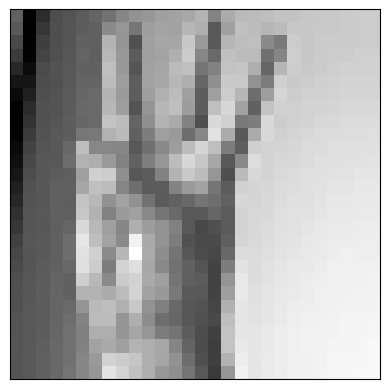

In [11]:
#pick an number to display one of the images
image=7
#use matplotlib to plot an image
picture = train_images[image]
#picture = picture.reshape(28,28) 

# Display the labelled digit for the picture
lbl = train_labels[image]
print("\nsign = ", lbl)

# Print a 'picture' of the sign
plt.imshow(picture, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show() 

In [12]:
#Print the new shape
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)
(27455,)


Now that everything is shaped and normalized I will build the network.  I added an additional convolutional layer 

In [13]:
# Add layersfrom keras.models import Sequential
model = Sequential()

### Convolutional Layers ###
# Convolutional Layer
model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu'))

model.add(Conv2D(128, (3, 3), input_shape=(28, 28, 1), activation='relu'))

# Max Pooling layer
from keras.layers import MaxPooling2D
model.add(MaxPooling2D(pool_size=(4, 4)))

model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu'))

# Max Pooling layer
from keras.layers import MaxPooling2D
model.add(MaxPooling2D(pool_size=(4, 4)))

model.add(Dense(units=100, activation='relu'))

#add flattening layer
from keras.layers import Flatten
model.add(Flatten())

model.add(Dropout(rate=0.5))


### 'ANN Layers' ###

model.add(Dense(units=128, activation='relu'))

#add softmax activation on dense layer for output
model.add(Dense(units=25, activation='softmax'))

e:\Repos\BootcampAll\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 1, 100)      │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,941 (667.74 KB)

 Trainable params: 170,941 (667.74 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

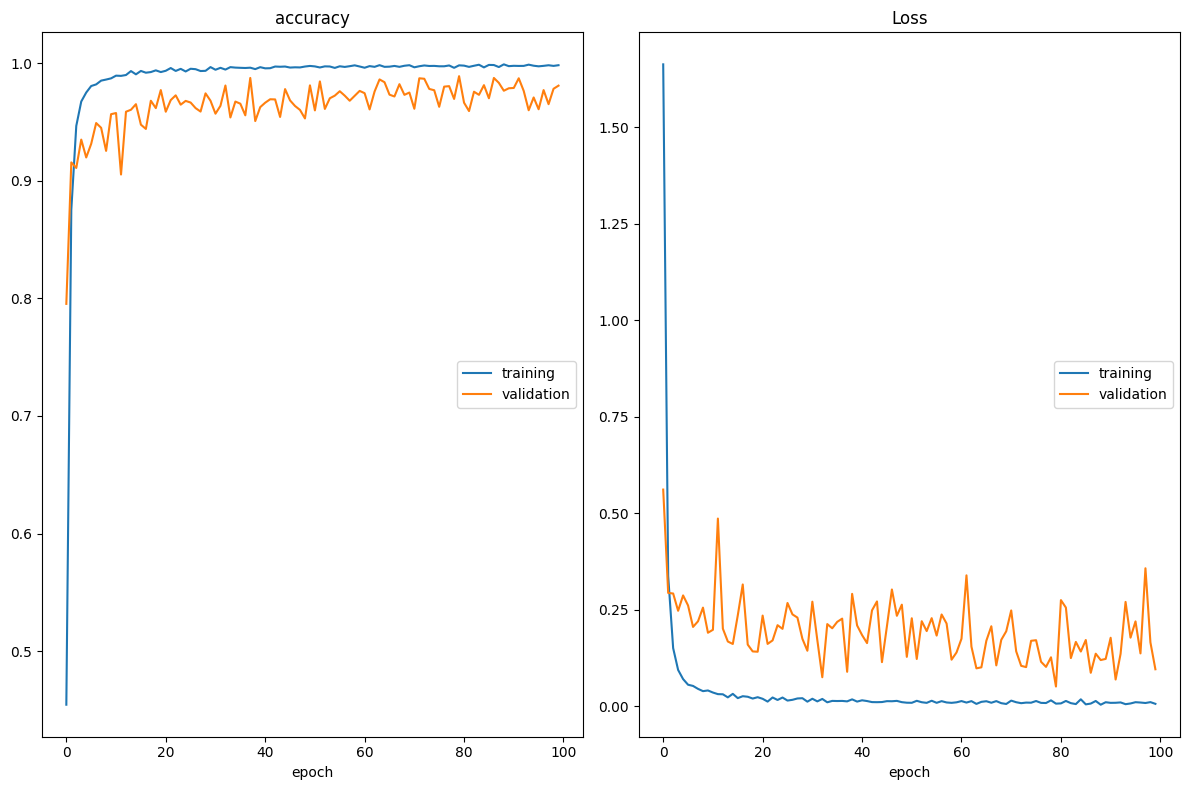

accuracy
	training         	 (min:    0.454, max:    0.999, cur:    0.998)
	validation       	 (min:    0.795, max:    0.989, cur:    0.981)
Loss
	training         	 (min:    0.004, max:    1.662, cur:    0.006)
	validation       	 (min:    0.051, max:    0.561, cur:    0.096)
858/858 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9989 - loss: 0.0038 - val_accuracy: 0.9809 - val_loss: 0.0958


In [16]:
model.fit(train_images, train_labels,
          epochs=100,
          batch_size = 32,
          validation_data=(test_images, test_labels),
          callbacks=[PlotLossesKeras()],
          verbose=1)

In [17]:
loss, accuracy = model.evaluate(test_images,test_labels)
print(accuracy)

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9787 - loss: 0.1060
0.9808979630470276


In [18]:
test_predict = np.argmax(model.predict(test_images), axis=1)


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [19]:
confusion_matrix = confusion_matrix(list(test_labels), list(test_predict))

In [20]:
confusion_matrix

array([[331,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 427,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   5,   0,   0,   0,   0],
       [  0,   0, 310,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 203,   1,   0,   0,   0,   0,   0,   0,   0,   9,
          0,   0,   0,   0,   0,  20,  11,   1,   0,   0,   0],
       [  0,   0,   0,   0, 496,   0,   0,   0,   0,   0,   0,   2,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 247,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 319,  11,   0,   0,   0,   0,   0,
          2,   0,   0,   0,   0,  16,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0

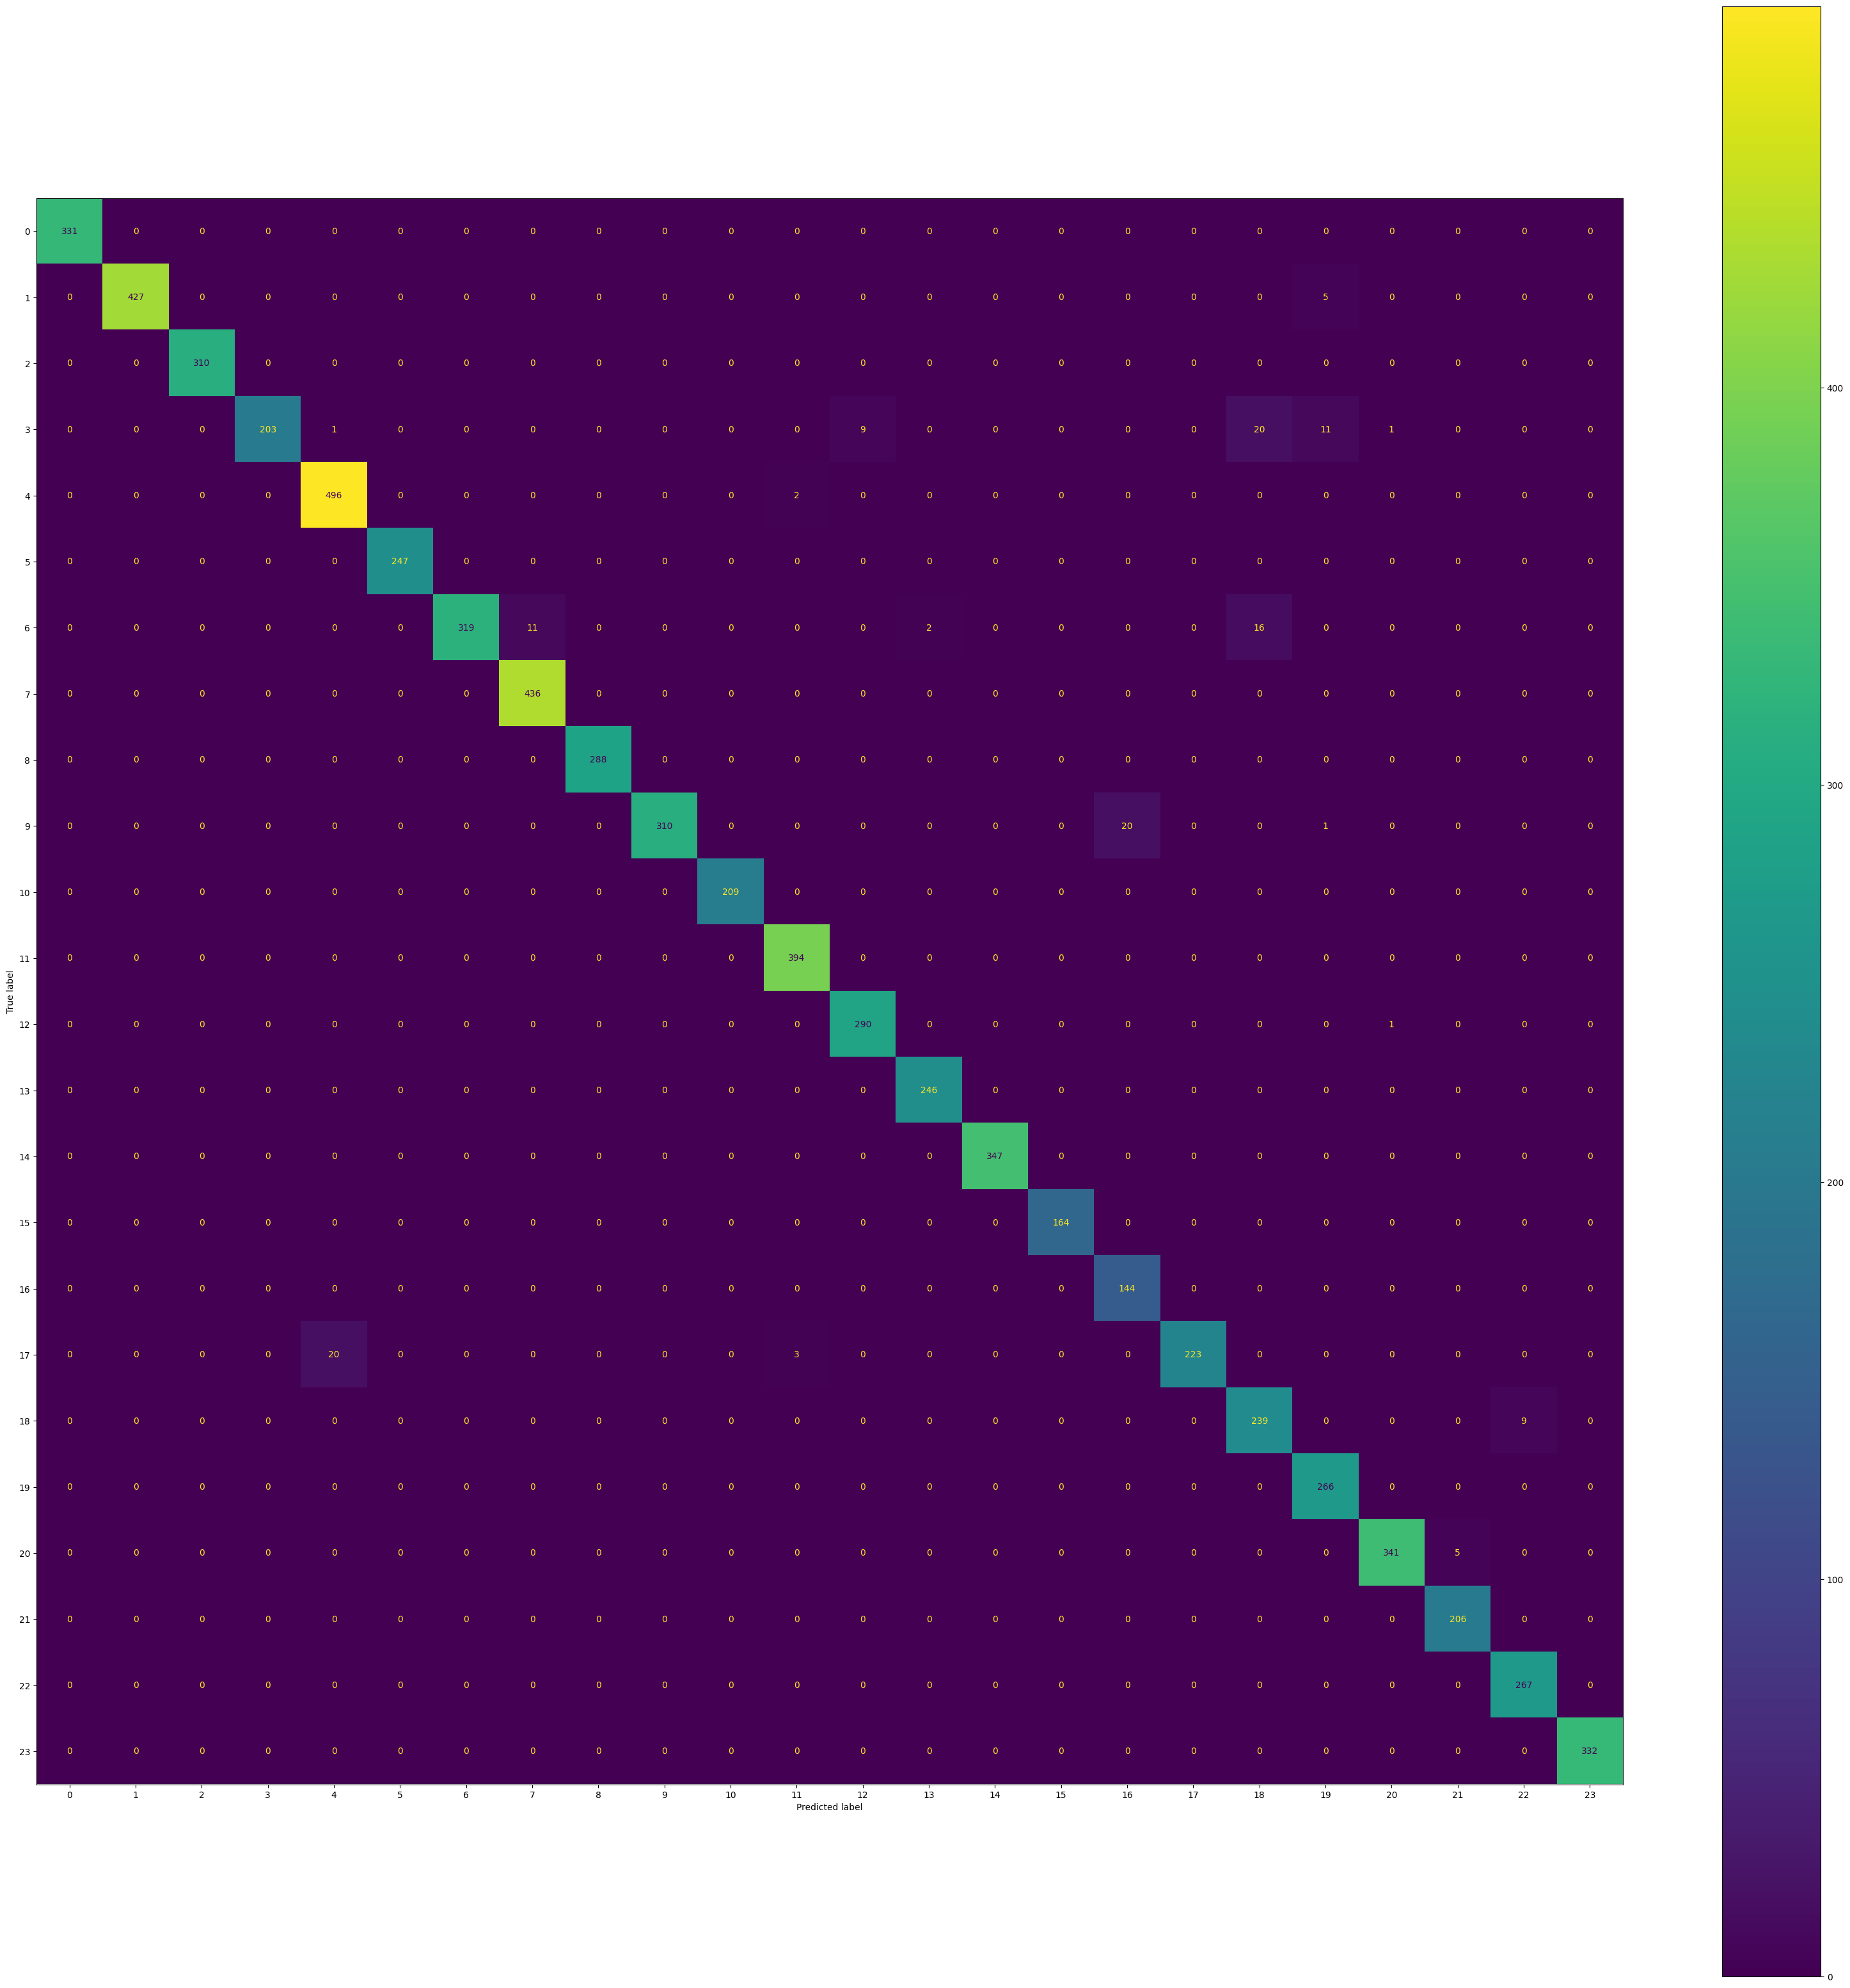

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix)

fig, ax = plt.subplots(figsize=(40,40))
disp.plot(ax=ax)
plt.show()

I had to make many changes as first when I used Steps per Epoch it was alternating between 0 and the accuracy in a zig zag pattern.  Amr mentioned he hadn't seen that before so it let to some educating exploration before we discovered that it needed to be changed to batch_size which fixed that issue.

Then I needed to make the model more complex to perform and added some additional density and a dropout layer.

Originally the model was scoring around 91-93% however I wanted to try to improve it, so I added 1 convolutional layer prior to the first pooling layer, then another after and another pooling layer which improved the model further to an accuracy of 97%.



Next I will show each letter of the alphabet from an image so that we can check with 5 random images from the internet.

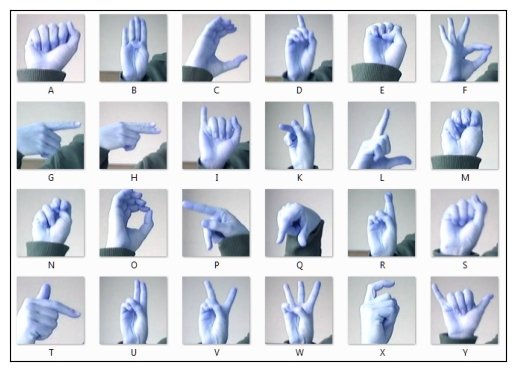

In [23]:
img = cv2.imread('amer_sign2.png')

# Print a 'picture' of the sign
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show() 

In [24]:
list_img = os.listdir('random5')

print(list_img)
#location 'E:/Repos/BootcampAll/Project/Module9 - AutoEncoder and Image/random5'

['img_01.jpg', 'img_02.jpg', 'img_03.jpg', 'img_04.jpg', 'img_05.jpg']


In [25]:
imgtest = []
random_predictions = []

for i in list_img:
   tempimg = cv2.imread('random5/'+i)
   tempimg = tempimg[:,:,0]
   imgtest.append(tempimg)
   #random_predictions_i = np.argmax(model.predict(i), axis=1)
   #random_predictions.append(random_predictions_i)
       #random_predict = np.argmax(model.predict(i), axis=1)
    

In [26]:
print(len(imgtest))
print(imgtest[0].shape)

5
(28, 28)


Reshape and standardize the 5 random tests and the labels to visualize

In [27]:
test = np.array([np.reshape(i, (28, 28, 1)) for i in imgtest])


In [28]:
test = test/255

In [29]:
test.shape

(5, 28, 28, 1)

In [30]:
random5_predict = np.argmax(model.predict(test), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [31]:
random5_predict

array([11, 10,  3, 20, 13], dtype=int64)

I decided on the letters that spell out "LEARN" in order so that we can easily check their accuracy!

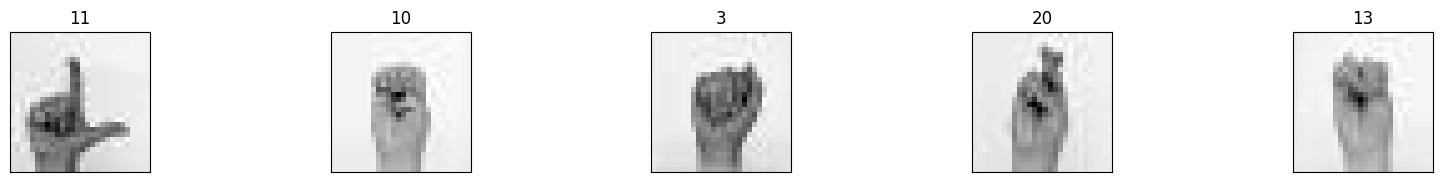

In [32]:
# Plot some examples
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # Reconstructed images
    #ax.set_title(random5_predict)
    
    ax = plt.subplot(2, n, i + 1 + n).set_title(random5_predict[i])
    plt.imshow(imgtest[i].reshape(28, 28))
    plt.gray()
    plt.xticks([])
    plt.yticks([])
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.show()